In [1]:
import numpy as np
import webdataset as wds
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms 
import os
import random

PATH_TO_DATA = "/mnt/analysis/analysis/rand_sharded_data/" 

In [2]:
image_normalize = transforms.Normalize(
                  mean=[0.17960437768666657, 0.14584139607643212, 0.10744440357398845, 0.2583671063835548],
                  std=[0.059635202669355195, 0.04059554002618016, 0.03371736326989986, 0.06295501902505744]
)

forcing_normalize = transforms.Normalize(
                  mean=[444.9605606256559, 991.7980623653417, 0.00039606951184754176, 96111.04161525163, 0.006652783216819315, 314.3219695851273, 2.82168247768119],
                  std=[5.5216369223813535, 12.951212256256913, 0.0002824274832735609, 975.3770569179914, 0.00012386107613000674, 0.6004463118907452, 0.34279194598853185]
)

forcing_mean = torch.from_numpy(np.array([444.9605606256559, 991.7980623653417, 0.00039606951184754176, 96111.04161525163, 0.006652783216819315, 314.3219695851273, 2.82168247768119]))
forcing_std = torch.from_numpy(np.array([5.5216369223813535, 12.951212256256913, 0.0002824274832735609, 975.3770569179914, 0.00012386107613000674, 0.6004463118907452, 0.34279194598853185]))

lst_mean = torch.from_numpy(np.array([312.8291360088677]))
lst_std = torch.from_numpy(np.array([11.376636496297289]))

In [3]:
def create_train_test(path_to_data, train_perc, test_perc):
    files = []
    for dirpath, dirnames, filenames in os.walk(path_to_data):
        files.extend(filenames)
    
    saturated = files[:-1]
    unsaturated = files[-1]
    
    dataset = wds.WebDataset(path_to_data + "/" + unsaturated)
    counter = 0
    for data in dataset:
        counter += 1
    
    total_files = counter + len(saturated) * 10000
    training_data = total_files * train_perc //10000
    test_data_files = total_files * test_perc //10000

    training_data = random.sample(files, int(training_data))
    test_data = [file for file in files if file not in training_data]
    test_data = random.sample(test_data, int(test_data_files))
    # Get sample sizes of train and test data
    training_samples = 0
    testing_samples = 0
    
    for path in training_data:
        if path in saturated:
            training_samples += 10000
        elif path in unsaturated:
            training_samples += counter
            
    for path in test_data:
        if path in saturated:
            testing_samples += 10000
        elif path in unsaturated:
            testing_samples += counter
            
            
    # Convert to filename lists 
    training_filepath = []
    for dat in training_data:
        training_filepath.append(dat[6:12])
    training_path = path_to_data + "shard-" + "{" + ",".join(training_filepath) + "}" + ".tar"
    
    testing_filepath = []
    for dat in test_data:
        testing_filepath.append(dat[6:12])
    testing_path = path_to_data + "shard-{" + ",".join(testing_filepath) +"}.tar"
    train_data = wds.WebDataset(training_path).shuffle(10000, initial=10000).decode("rgb").rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
    test_data = wds.WebDataset(testing_path).decode("rgb").shuffle(10000, initial=10000).rename(image="image.pyd", forcing="forcing.pyd", lst = "lst.pyd").to_tuple("image", "forcing", "lst")
            
    return (train_data, training_samples), (test_data, testing_samples)
    
(train_data, training_samples_len), (test_data, testing_samples_len) = create_train_test(PATH_TO_DATA, 0.85, 0.15)


In [4]:
class LSTModel(nn.Module):
    def __init__(self, input_shape=(4,33,33), forcing_shape=(1,7)):
        super(LSTModel, self).__init__()
        self.in_channels = input_shape[0]
        self.input_shape = input_shape
        
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=8, kernel_size=(3,3))
        self.conv1_bn = nn.BatchNorm2d(8)
        self.mp1 = nn.AvgPool2d(kernel_size=(3,3), stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3))
        self.conv2_bn = nn.BatchNorm2d(16)
        self.mp2 = nn.AvgPool2d(kernel_size=(3, 3), stride=2)
#         self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1))
#         self.conv3_bn = nn.BatchNorm2d(8)

        self.flatten_shape = None
        zero_ex = torch.zeros(input_shape).unsqueeze(0)
        zero_forcing = torch.zeros(forcing_shape)
        
        with torch.no_grad():
            self.convolutions(zero_ex, zero_forcing)
        
        print(self.flatten_shape)
        self.fc1 = nn.Linear(in_features=self.flatten_shape, out_features=128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
#         self.drop3 = nn.Dropout(0)
#         self.fc4 = nn.Linear(in_features=64, out_features=1)
        
    def convolutions(self, x, forcing):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)))
        x = self.mp1(x)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)))
        x = self.mp2(x)
#         x = F.leaky_relu(self.conv3_bn(self.conv3(x)))
#         x = self.mp3(x)

        # Reshape for linear
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, forcing), dim=1)

        if self.flatten_shape is None:
            self.flatten_shape = x.shape[1]

        return x
    
    def forward(self, x, forcing):
        x = self.convolutions(x, forcing)
        x = F.leaky_relu(self.fc_bn1(self.fc1(x)))
        x = self.drop1(x)
        x = F.leaky_relu(self.fc_bn2(self.fc2(x)))
        x = self.drop2(x)
        x = self.fc3(x)
#         x = self.drop3(x)
#         x = self.fc4(x)
        
        return x
        

In [5]:
from tqdm import tqdm

EPOCHS = 100
LEARNING_RATE = 0.00005
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1024

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=6)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=6)

model = LSTModel().to(DEVICE)
model = torch.nn.DataParallel(model, device_ids=[0,1])
loss_fn = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.95)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.0005)
test_loss = []
train_loss = []

lst_mean = lst_mean.to(DEVICE)
lst_std = lst_std.to(DEVICE)
forcing_mean = forcing_mean.to(DEVICE)
forcing_std = forcing_std.to(DEVICE)

def process_data(image, forcing, lst):
    image, forcing, lst = image.to(torch.float32).to(DEVICE), forcing.to(DEVICE), lst.to(DEVICE)
    # Image Transformations
    image = torch.clip(image, min=0, max=1)
#     image = image_normalize(image)
    # Forcing Transformation
    forcing = torch.div(torch.sub(forcing, forcing_mean), forcing_std).to(torch.float32)
    # LST Transformation
#     lst = torch.div(torch.sub(lst, lst_mean), lst_std).to(torch.float32).view(-1, 1)
    lst = lst.view(-1, 1).to(torch.float32)
    return image, forcing, lst

min_test_loss = np.inf    
for epoch in range(EPOCHS):
    print("****** EPOCH: [{}/{}] LR: {} ******".format(epoch, EPOCHS, round(optimizer.param_groups[0]['lr'], 6)))
    running_train_loss = 0
    train_n_iter = 0
    running_test_loss = 0
    test_n_iter = 0
    
    loop_train = tqdm(train_loader, total=(training_samples_len//BATCH_SIZE) + 1, leave=True)
    for idx, (image, forcing, lst) in enumerate(loop_train):
        image, forcing, lst = process_data(image, forcing, lst)
        optimizer.zero_grad()
        forward_out = model.forward(image, forcing)
        loss = loss_fn(forward_out, lst)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        train_n_iter += 1
        loop_train.set_postfix(train_loss=loss.item())
        
    loop_test = tqdm(test_loader, total=(testing_samples_len//BATCH_SIZE) + 1, leave=False)
    
    with torch.no_grad():
        for idx, (image, forcing, lst) in enumerate(loop_test):
            image, forcing, lst = process_data(image, forcing, lst)
            pred = model.forward(image, forcing)
            testloss = loss_fn(pred, lst)
            running_test_loss += testloss.item()
            test_n_iter += 1
            loop_test.set_postfix(test_loss=testloss.item())

    avg_train_loss = running_train_loss/train_n_iter
    train_loss.append(avg_train_loss)
    avg_test_loss = running_test_loss/test_n_iter
    test_loss.append(avg_test_loss)
    
    scheduler.step()
    scheduler2.step(avg_test_loss)
    if avg_test_loss < min_test_loss:
        print("Saving Model")
        min_test_loss = avg_test_loss
        torch.save(model.state_dict(), "lstmodel.pt")
    print("------ Train Loss: {}, Test Loss: {} ------".format(avg_train_loss, avg_test_loss))
            
        
        
        
        

583
****** EPOCH: [0/100] LR: 5e-05 ******


1712it [03:28,  8.22it/s, train_loss=272]                                                                                                             


Saving Model
------ Train Loss: 298.96240195158487, Test Loss: 272.1613964281584 ------
****** EPOCH: [1/100] LR: 5e-05 ******


1712it [03:29,  8.18it/s, train_loss=8.02]                                                                                                            


Saving Model
------ Train Loss: 141.9150059189752, Test Loss: 7.4343852777230115 ------
****** EPOCH: [2/100] LR: 4.9e-05 ******


1712it [03:29,  8.17it/s, train_loss=6.51]                                                                                                            


Saving Model
------ Train Loss: 6.924757671411906, Test Loss: 6.493235719831366 ------
****** EPOCH: [3/100] LR: 4.9e-05 ******


1712it [03:27,  8.23it/s, train_loss=6.27]                                                                                                            


Saving Model
------ Train Loss: 6.387936550044568, Test Loss: 6.232335081225948 ------
****** EPOCH: [4/100] LR: 4.8e-05 ******


1712it [03:31,  8.09it/s, train_loss=5.97]                                                                                                            


Saving Model
------ Train Loss: 6.120662716783095, Test Loss: 6.011028804277119 ------
****** EPOCH: [5/100] LR: 4.8e-05 ******


1712it [03:28,  8.23it/s, train_loss=5.83]                                                                                                            


Saving Model
------ Train Loss: 5.922310895173349, Test Loss: 5.88211945012996 ------
****** EPOCH: [6/100] LR: 4.7e-05 ******


1712it [03:30,  8.15it/s, train_loss=5.73]                                                                                                            


Saving Model
------ Train Loss: 5.777873745031446, Test Loss: 5.766486004779213 ------
****** EPOCH: [7/100] LR: 4.7e-05 ******


1712it [03:25,  8.33it/s, train_loss=5.65]                                                                                                            


Saving Model
------ Train Loss: 5.668835065910749, Test Loss: 5.683059919821589 ------
****** EPOCH: [8/100] LR: 4.6e-05 ******


1712it [03:29,  8.18it/s, train_loss=5.58]                                                                                                            


Saving Model
------ Train Loss: 5.581489594183235, Test Loss: 5.595777580612584 ------
****** EPOCH: [9/100] LR: 4.6e-05 ******


1712it [03:27,  8.23it/s, train_loss=5.52]                                                                                                            


Saving Model
------ Train Loss: 5.505761544002551, Test Loss: 5.5238101043199235 ------
****** EPOCH: [10/100] LR: 4.5e-05 ******


1712it [03:28,  8.23it/s, train_loss=5.45]                                                                                                            


Saving Model
------ Train Loss: 5.435730120846045, Test Loss: 5.445756400886335 ------
****** EPOCH: [11/100] LR: 4.5e-05 ******


1712it [03:29,  8.16it/s, train_loss=5.29]                                                                                                            


Saving Model
------ Train Loss: 5.36952701795881, Test Loss: 5.374665831264696 ------
****** EPOCH: [12/100] LR: 4.4e-05 ******


1712it [03:28,  8.20it/s, train_loss=5.17]                                                                                                            


Saving Model
------ Train Loss: 5.303414386566554, Test Loss: 5.365933021432475 ------
****** EPOCH: [13/100] LR: 4.4e-05 ******


1712it [03:31,  8.08it/s, train_loss=5.11]                                                                                                            


Saving Model
------ Train Loss: 5.24608706926631, Test Loss: 5.319542269957693 ------
****** EPOCH: [14/100] LR: 4.3e-05 ******


1712it [03:28,  8.20it/s, train_loss=5.02]                                                                                                            


Saving Model
------ Train Loss: 5.195962969944856, Test Loss: 5.254260187086306 ------
****** EPOCH: [15/100] LR: 4.3e-05 ******


1712it [03:30,  8.13it/s, train_loss=4.96]                                                                                                            


Saving Model
------ Train Loss: 5.15020373825715, Test Loss: 5.229199589867341 ------
****** EPOCH: [16/100] LR: 4.3e-05 ******


1712it [03:29,  8.15it/s, train_loss=5]                                                                                                               


Saving Model
------ Train Loss: 5.115896579261138, Test Loss: 5.223089720073499 ------
****** EPOCH: [17/100] LR: 4.2e-05 ******


1712it [03:32,  8.07it/s, train_loss=4.95]                                                                                                            


------ Train Loss: 5.082170468624507, Test Loss: 5.235560297966003 ------
****** EPOCH: [18/100] LR: 4.2e-05 ******


1712it [03:32,  8.07it/s, train_loss=4.9]                                                                                                             


Saving Model
------ Train Loss: 5.050291481976197, Test Loss: 5.21128047610584 ------
****** EPOCH: [19/100] LR: 4.1e-05 ******


1712it [03:30,  8.13it/s, train_loss=4.84]                                                                                                            


Saving Model
------ Train Loss: 5.026738352586176, Test Loss: 5.173607060783787 ------
****** EPOCH: [20/100] LR: 4.1e-05 ******


1712it [03:32,  8.04it/s, train_loss=4.8]                                                                                                             


Saving Model
------ Train Loss: 5.004080455993938, Test Loss: 5.173250631282204 ------
****** EPOCH: [21/100] LR: 4e-05 ******


1712it [03:28,  8.22it/s, train_loss=4.82]                                                                                                            


Saving Model
------ Train Loss: 4.982053536678029, Test Loss: 5.131355083302448 ------
****** EPOCH: [22/100] LR: 4e-05 ******


1712it [03:30,  8.13it/s, train_loss=4.8]                                                                                                             


Saving Model
------ Train Loss: 4.958767231101188, Test Loss: 5.110552938360917 ------
****** EPOCH: [23/100] LR: 4e-05 ******


1712it [03:29,  8.17it/s, train_loss=4.74]                                                                                                            


------ Train Loss: 4.9385502550089475, Test Loss: 5.122343599796295 ------
****** EPOCH: [24/100] LR: 3.9e-05 ******


1712it [03:30,  8.14it/s, train_loss=4.77]                                                                                                            


Saving Model
------ Train Loss: 4.924228936712319, Test Loss: 5.025449159898256 ------
****** EPOCH: [25/100] LR: 3.9e-05 ******


1712it [03:29,  8.19it/s, train_loss=4.74]                                                                                                            


------ Train Loss: 4.909580896112407, Test Loss: 5.036782885852613 ------
****** EPOCH: [26/100] LR: 3.9e-05 ******


1712it [03:29,  8.18it/s, train_loss=4.72]                                                                                                            


Saving Model
------ Train Loss: 4.892680312428519, Test Loss: 5.024973074072285 ------
****** EPOCH: [27/100] LR: 3.8e-05 ******


1712it [03:26,  8.27it/s, train_loss=4.7]                                                                                                             


Saving Model
------ Train Loss: 4.878425622933379, Test Loss: 4.994588897416466 ------
****** EPOCH: [28/100] LR: 3.8e-05 ******


1712it [03:29,  8.16it/s, train_loss=4.68]                                                                                                            


------ Train Loss: 4.8661311201960125, Test Loss: 5.012897125984493 ------
****** EPOCH: [29/100] LR: 3.7e-05 ******


1712it [03:28,  8.21it/s, train_loss=4.65]                                                                                                            


------ Train Loss: 4.853950182411158, Test Loss: 5.015660715730567 ------
****** EPOCH: [30/100] LR: 3.7e-05 ******


1712it [03:30,  8.14it/s, train_loss=4.65]                                                                                                            


------ Train Loss: 4.8448568120181, Test Loss: 4.996561219817714 ------
****** EPOCH: [31/100] LR: 3.7e-05 ******


1712it [03:31,  8.11it/s, train_loss=4.66]                                                                                                            


Saving Model
------ Train Loss: 4.831676854151431, Test Loss: 4.946368085710626 ------
****** EPOCH: [32/100] LR: 3.6e-05 ******


1712it [03:30,  8.15it/s, train_loss=4.63]                                                                                                            


Saving Model
------ Train Loss: 4.8172742245353275, Test Loss: 4.939218047418092 ------
****** EPOCH: [33/100] LR: 3.6e-05 ******


1712it [03:31,  8.11it/s, train_loss=4.62]                                                                                                            


------ Train Loss: 4.809630365711507, Test Loss: 4.940231050315656 ------
****** EPOCH: [34/100] LR: 3.6e-05 ******


1712it [03:30,  8.15it/s, train_loss=4.62]                                                                                                            


------ Train Loss: 4.7995239980866975, Test Loss: 5.014884162890284 ------
****** EPOCH: [35/100] LR: 3.5e-05 ******


1712it [03:30,  8.15it/s, train_loss=4.6]                                                                                                             


------ Train Loss: 4.7903916298229, Test Loss: 4.975357720726414 ------
****** EPOCH: [36/100] LR: 3.5e-05 ******


 68%|██████████████████████████████████████████████████████████████▌                             | 1163/1710 [02:28<01:09,  7.83it/s, train_loss=4.37]


KeyboardInterrupt: 

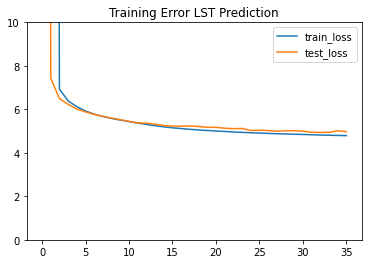

In [8]:
import matplotlib.pyplot as plt
# plot lines
plt.plot(list(range(0,36)), train_loss, label = "train_loss")
plt.plot(list(range(0,36)), test_loss, label = "test_loss")
plt.legend()
plt.title("Training Error LST Prediction")
plt.savefig("Training Curve.png")
plt.ylim([0, 10])
plt.show()

In [ ]:
plt.savefig()